In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import os
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation , BatchNormalization

2023-12-01 20:40:01.582938: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-01 20:40:01.634486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-01 20:40:01.634517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-01 20:40:01.634523: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-01 20:40:01.642164: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
def train_val_generators(TRAINING_DIR, TEST_DIR):

  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,      # Rotate images by up to 40 degrees
                                     width_shift_range=0.2,  # Shift width by up to 20%
                                     height_shift_range=0.2, # Shift height by up to 20%
                                     shear_range=0.2,        # Shear angle by up to 20%
                                     zoom_range=0.2,         # Zoom in/out by up to 20%
                                     horizontal_flip=True,   # Flip horizontally
                                     fill_mode='nearest')
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))
  validation_datagen = ImageDataGenerator(rescale=1/255)
  

  test_datagen = ImageDataGenerator(rescale=1/255, 
                                   validation_split=0.4)
  validation_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(224, 224),
                                                                subset='validation')
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=256,
                                                                class_mode='categorical',
                                                                target_size=(224, 224), 
                                                                subset='training')

  return train_generator, validation_generator, test_generator

In [4]:
train_generator, validation_generator, test_generator = train_val_generators('Chest_CTScan_dataset-main/train', 'Chest_CTScan_dataset-main/test')

Found 613 images belonging to 4 classes.
Found 125 images belonging to 4 classes.
Found 190 images belonging to 4 classes.


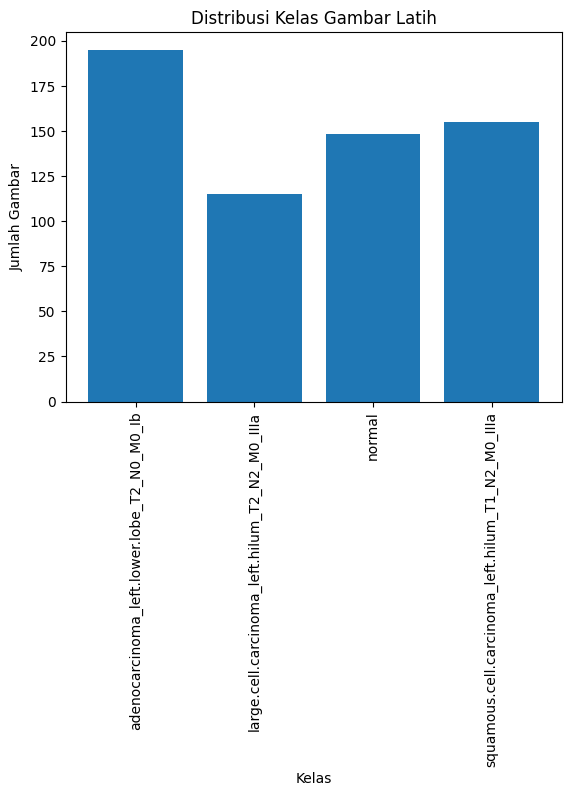

In [6]:
# Menghitung jumlah data per kelas
num_classes_train = len(train_generator.class_indices)
class_counts_train = np.zeros(num_classes_train)

for i in range(len(train_generator)):
    batch_labels_train = np.argmax(train_generator[i][1], axis=1)
    class_counts_train += np.bincount(batch_labels_train, minlength=num_classes)

# Mendapatkan nama kelas
class_names_train = list(train_generator.class_indices.keys())

plt.bar(class_names_train, class_counts_train)
plt.title('Distribusi Kelas Gambar Latih')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=90)
plt.show()

In [9]:
print(class_names_train, class_counts_train)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'] [195. 115. 148. 155.]


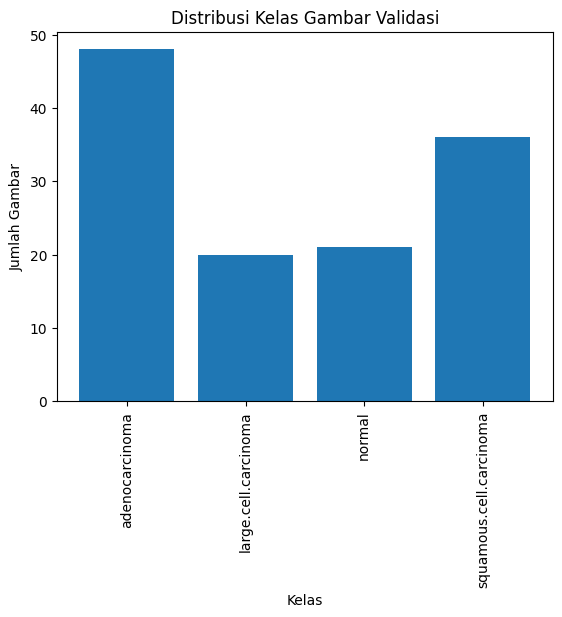

In [7]:
# Menghitung jumlah data per kelas
num_classes_val = len(validation_generator.class_indices)
class_counts_val = np.zeros(num_classes_val)

for i in range(len(validation_generator)):
    batch_labels_val = np.argmax(validation_generator[i][1], axis=1)
    class_counts_val += np.bincount(batch_labels_val, minlength=num_classes)

# Mendapatkan nama kelas
class_names_val = list(validation_generator.class_indices.keys())

plt.bar(class_names_val, class_counts_val)
plt.title('Distribusi Kelas Gambar Validasi')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=90)
plt.show()

In [10]:
print(class_names_val, class_counts_val)

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'] [48. 20. 21. 36.]


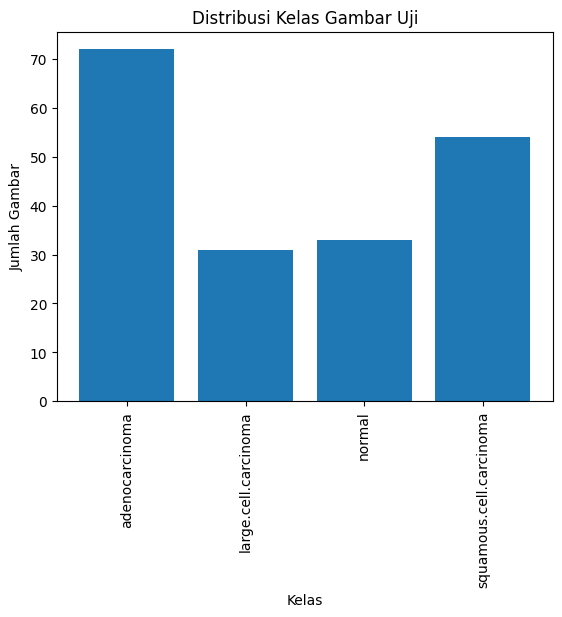

In [8]:
# Menghitung jumlah data per kelas
num_classes_test = len(test_generator.class_indices)
class_counts_test = np.zeros(num_classes_test)

for i in range(len(test_generator)):
    batch_labels_test = np.argmax(test_generator[i][1], axis=1)
    class_counts_test += np.bincount(batch_labels_test, minlength=num_classes)

# Mendapatkan nama kelas
class_names_test = list(test_generator.class_indices.keys())

plt.bar(class_names_test, class_counts_test)
plt.title('Distribusi Kelas Gambar Uji')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=90)
plt.show()

In [11]:
print(class_names_test, class_counts_test)

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma'] [72. 31. 33. 54.]


In [5]:
def InceptionV4():

    input_layer = Input(shape=(224 , 224 , 3))

    x = stemBlock(prev_layer=input_layer)

    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)

    x = reduction_A_Block(prev_layer=x)

    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)

    x = reduction_B_Block(prev_layer= x)

    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(units = 1536, activation='relu') (x)
    x = Dropout(rate = 0.8) (x)
    x = Dense(units = 1000, activation='relu')(x)

    model = Model(inputs = input_layer , outputs = x , name ='Inception-V4')

    return model

In [6]:
def conv2d_with_Batch(prev_layer , nbr_kernels , filter_size , strides = (1,1) , padding = 'valid'):
    x = Conv2D(filters = nbr_kernels, kernel_size = filter_size, strides=strides , padding=padding) (prev_layer)
    x = BatchNormalization()(x)
    x = Activation(activation = 'relu') (x)
    return x

In [7]:
def stemBlock(prev_layer):
    x = conv2d_with_Batch(prev_layer, nbr_kernels = 32, filter_size = (3,3), strides = (2,2))
    x = conv2d_with_Batch(x, nbr_kernels = 32, filter_size = (3,3))
    x = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (3,3))

    x_1 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (3,3), strides = (2,2) )
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)

    x = concatenate([x_1 , x_2], axis = 3)

    x_1 = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (1,7) , padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (7,1), padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 96, filter_size = (3,3))

    x_2 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (1,1))
    x_2 = conv2d_with_Batch(x_2, nbr_kernels = 96, filter_size = (3,3))

    x = concatenate([x_1 , x_2], axis = 3)

    x_1 = conv2d_with_Batch(x, nbr_kernels = 192, filter_size = (3,3) , strides=2)
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)

    x = concatenate([x_1 , x_2], axis = 3)

    return x

In [8]:
def reduction_A_Block(prev_layer) :
    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (3,3) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,3) , strides=(2,2))

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (3,3) , strides=(2,2))

    x_3 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)

    x = concatenate([x_1 , x_2 , x_3], axis = 3)

    return x

In [9]:
def reduction_B_Block(prev_layer):
    x_1 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 192, filter_size = (3,3) , strides=(2,2) )

    x_3 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1) )
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = (1,7) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (7,1) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (3,3) , strides=(2,2))

    x = concatenate([x_1 , x_2 , x_3], axis = 3)
    return x

In [10]:
def InceptionBlock_A(prev_layer): #I'm Here

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1), padding='same' )
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1) , padding='same')

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 96, filter_size = (3,3) , padding='same')

    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 96, filter_size = (1,1) , padding='same')

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 96, filter_size = (1,1))

    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)

    return output

In [11]:
def InceptionBlock_B(prev_layer):

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 192, filter_size = (1,7) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (7,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (7,1), padding='same')

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (1,7), padding='same')

    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 128, filter_size = (1,1))

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))

    output = concatenate([x_1 , x_2 ,x_3, x_4], axis = 3)
    return output

In [12]:
def InceptionBlock_C(prev_layer):

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 448, filter_size = (1,3) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 512, filter_size = (3,1) , padding='same')
    x_1_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_1_2 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_1 = concatenate([x_1_1 , x_1_2], axis = 3)

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_2_1 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_2_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_2 = concatenate([x_2_1 , x_2_2], axis = 3)

    x_3 = AveragePooling2D(pool_size=(3,3),strides = 1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = 3  , padding='same')

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1))

    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)

    return output

In [13]:
model = InceptionV4()

# Custom Last Stage
x = model.output
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=model.input, outputs=predictions)

# Compile
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

2023-12-01 20:40:11.174573: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10436 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [14]:
filepath = 'models/PCD-test-aug-checkpoint.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True
        
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
    mode='max'
)

In [15]:
callbacksList = [myCallback()]
history1 = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=200,
                    callbacks = callbacksList,
                    verbose=1)

Epoch 1/200


2023-12-01 18:39:55.282113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-01 18:39:56.924798: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 18:39:57.199057: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 18:39:59.291034: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fad27913490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 18:39:59.291067: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-01 18:39:59.295907: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 18:39:59.447264: I ./tensorflow/compiler/jit/device_compiler.h:1

20/20 [==============================] - 121s 1s/step - loss: 1.6694 - accuracy: 0.3785 - val_loss: 90.4256 - val_accuracy: 0.1680
Epoch 2/200
20/20 [==============================] - 9s 436ms/step - loss: 1.6663 - accuracy: 0.4649 - val_loss: 39.8784 - val_accuracy: 0.1680
Epoch 3/200
20/20 [==============================] - 9s 436ms/step - loss: 1.6995 - accuracy: 0.3801 - val_loss: 639.4233 - val_accuracy: 0.1680
Epoch 4/200
20/20 [==============================] - 8s 409ms/step - loss: 1.9363 - accuracy: 0.4698 - val_loss: 22.2018 - val_accuracy: 0.1680
Epoch 5/200
20/20 [==============================] - 9s 436ms/step - loss: 1.4118 - accuracy: 0.4046 - val_loss: 1.6293 - val_accuracy: 0.3840
Epoch 6/200
20/20 [==============================] - 9s 436ms/step - loss: 1.0840 - accuracy: 0.5057 - val_loss: 2.2288 - val_accuracy: 0.2880
Epoch 7/200
20/20 [==============================] - 9s 435ms/step - loss: 1.0895 - accuracy: 0.4747 - val_loss: 2.0383 - val_accuracy: 0.1600
Epoch 8

In [17]:
model.save('PCD-test-aug-callback.h5')

/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
callbacksList = [modelCheckpoint]
history2 = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=200,
                    callbacks = callbacksList,
                    verbose=1)

Epoch 1/200


2023-12-01 19:16:09.819699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-01 19:16:11.425223: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 19:16:11.747290: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 19:16:17.942134: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7e5bc5ac60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 19:16:17.942216: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-01 19:16:18.071254: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 19:16:18.885478: I ./tensorflow/compiler/jit/device_compiler.h:1

20/20 [==============================] - ETA: 0s - loss: 1.7091 - accuracy: 0.3719
Epoch 1: val_accuracy improved from -inf to 0.16800, saving model to models/PCD-test-aug-checkpoint.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 127s 1s/step - loss: 1.7091 - accuracy: 0.3719 - val_loss: 1.4853 - val_accuracy: 0.1680
Epoch 2/200
20/20 [==============================] - ETA: 0s - loss: 1.4970 - accuracy: 0.4568
Epoch 2: val_accuracy did not improve from 0.16800
20/20 [==============================] - 9s 459ms/step - loss: 1.4970 - accuracy: 0.4568 - val_loss: 8.7899 - val_accuracy: 0.1680
Epoch 3/200
20/20 [==============================] - ETA: 0s - loss: 2.0055 - accuracy: 0.4241
Epoch 3: val_accuracy did not improve from 0.16800
20/20 [==============================] - 8s 384ms/step - loss: 2.0055 - accuracy: 0.4241 - val_loss: 2.9879 - val_accuracy: 0.1680
Epoch 4/200
20/20 [==============================] - ETA: 0s - loss: 1.7012 - accuracy: 0.4160
Epoch 4: val_accuracy did not improve from 0.16800
20/20 [==============================] - 9s 437ms/step - loss: 1.7012 - accuracy: 0.4160 - val_loss: 13.2263 - val_accuracy: 0.1680
Epoch 5/200
20/20 [===================

In [15]:
callbacksList = [earlyStopping]
history3 = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=200,
                    callbacks = callbacksList,
                    verbose=1)
model.save('PCD-test-aug-early-stopping.h5')

Epoch 1/200


2023-12-01 20:41:07.916660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-01 20:41:08.664996: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 20:41:08.898104: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 20:41:10.673340: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd1662c03b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 20:41:10.673380: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-01 20:41:10.678239: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 20:41:10.831071: I ./tensorflow/compiler/jit/device_compiler.h:1

20/20 [==============================] - 119s 1s/step - loss: 2.0522 - accuracy: 0.4144 - val_loss: 1.5546 - val_accuracy: 0.1600
Epoch 2/200
20/20 [==============================] - 9s 433ms/step - loss: 1.3339 - accuracy: 0.4421 - val_loss: 94.0044 - val_accuracy: 0.1680
Epoch 3/200
20/20 [==============================] - 8s 404ms/step - loss: 1.8346 - accuracy: 0.4600 - val_loss: 384.3224 - val_accuracy: 0.1680
Epoch 4/200
20/20 [==============================] - 9s 418ms/step - loss: 1.3715 - accuracy: 0.4144 - val_loss: 407.1097 - val_accuracy: 0.1680
Epoch 5/200
20/20 [==============================] - 9s 430ms/step - loss: 1.6218 - accuracy: 0.4356 - val_loss: 581.8531 - val_accuracy: 0.1680
Epoch 6/200
20/20 [==============================] - 9s 432ms/step - loss: 1.3889 - accuracy: 0.4715 - val_loss: 16.6023 - val_accuracy: 0.1680
Epoch 7/200
20/20 [==============================] - 9s 424ms/step - loss: 1.3802 - accuracy: 0.4731 - val_loss: 1.8116 - val_accuracy: 0.3840
Epoc

/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


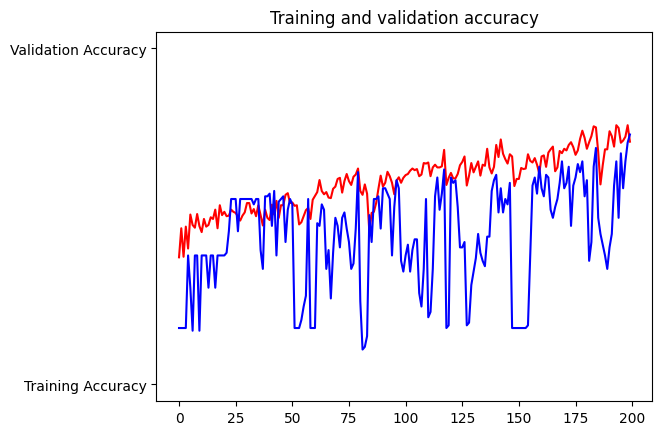

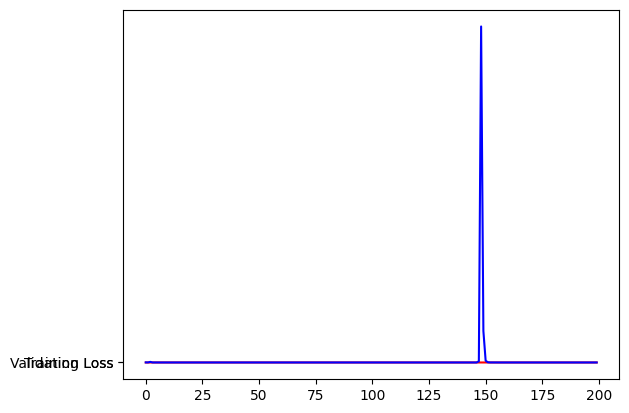

In [16]:
acc=history1.history['accuracy']
val_acc=history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

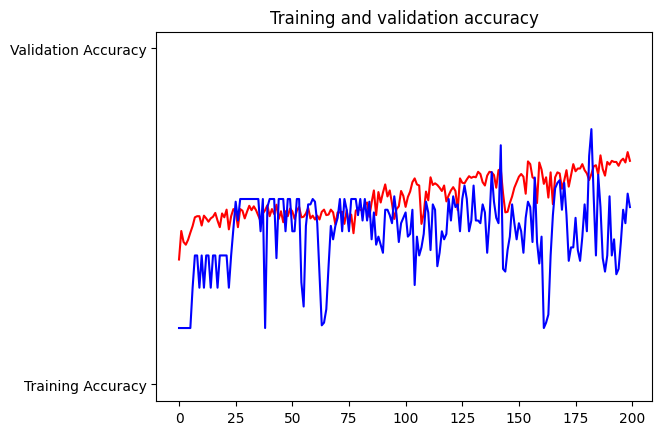

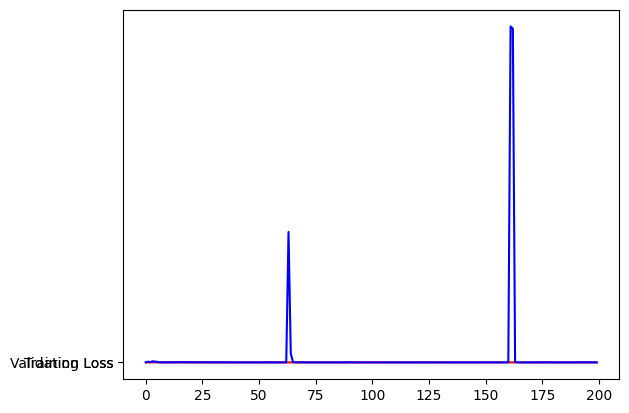

In [16]:
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

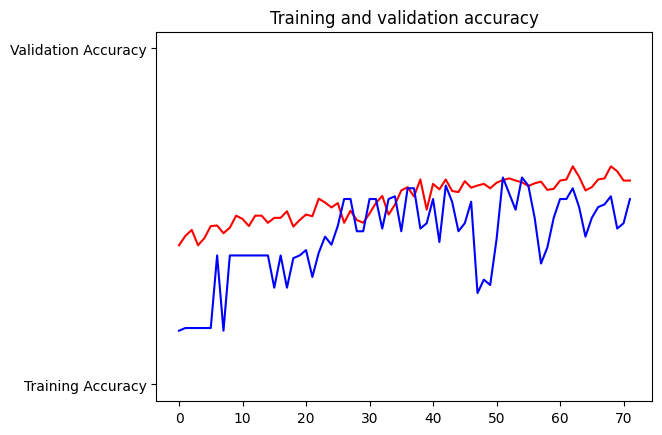

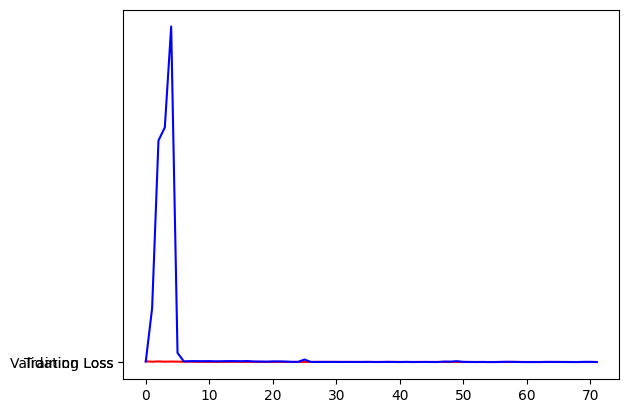

In [16]:
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [6]:
load_model = tf.keras.models.load_model('models/PCD-test-no-aug-no-patience.h5')

2023-11-13 12:14:34.751521: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-13 12:14:34.751554: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-13 12:14:34.751864: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  190  y:  190


In [8]:
pred = load_model.predict(x)

y_test = []
for i in pred:
    y_test.append(np.argmax(i))

y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

6/6 [==============================] - 5s 504ms/step


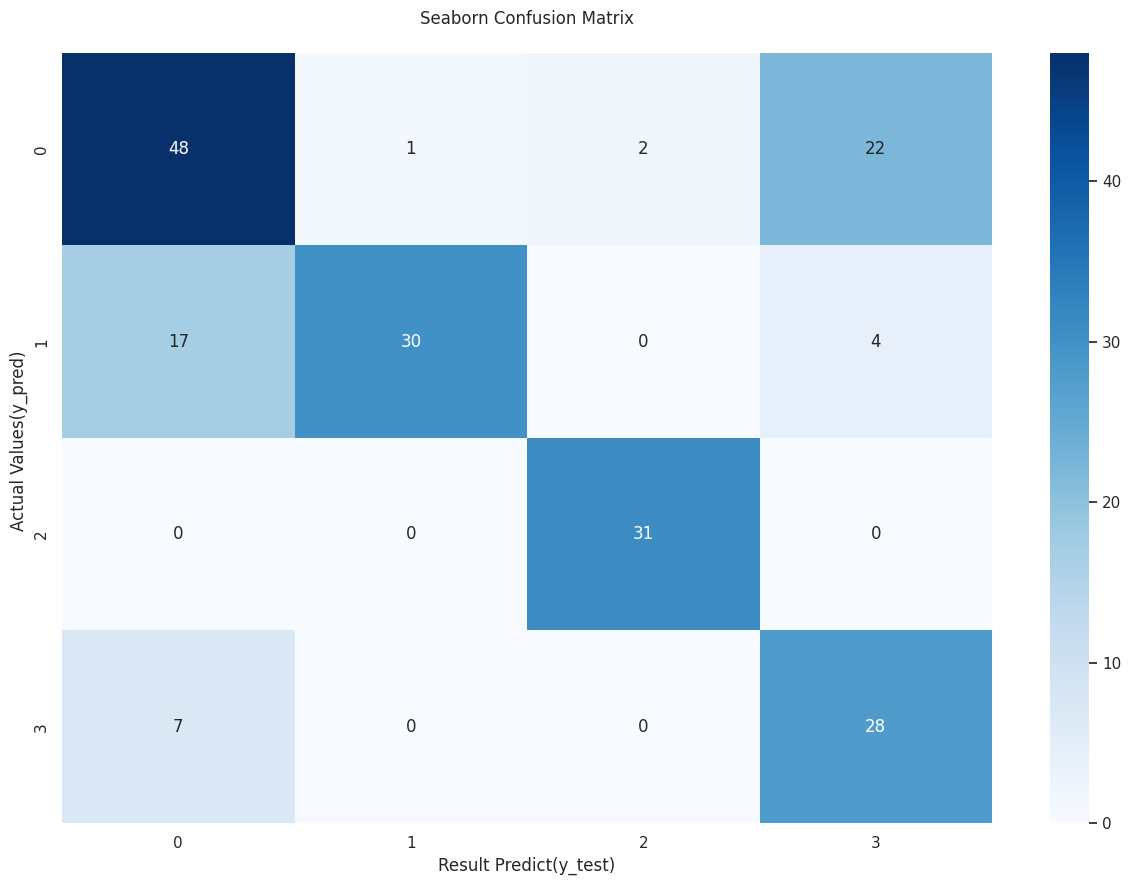

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ');

In [10]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.66      0.66        73
           1       0.97      0.59      0.73        51
           2       0.94      1.00      0.97        31
           3       0.52      0.80      0.63        35

    accuracy                           0.72       190
   macro avg       0.77      0.76      0.75       190
weighted avg       0.76      0.72      0.72       190



In [11]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

precision2 = precision_score(y_test, y_pred, average='micro')
recall2 = recall_score(y_test, y_pred, average='micro')
f1score2 = f1_score(y_test, y_pred, average='micro')

print(f"Precision = {precision2}")
print(f"Recall = {recall2}")
print(f"F1 Score = {f1score2}")

Precision = 0.7210526315789474
Recall = 0.7210526315789474
F1 Score = 0.7210526315789474
